Let's generate a catalog of planets, including binary stars.  There are parameters controlling both the planet population and the binary star population:

$$ \theta = (F, \alpha, \beta, f_B, \gamma) $$

$F$, $\alpha$ and $\beta$ are the power-law parameters of the true planet population, $f_B$ is the binary fraction, and $\gamma$ is the mass-ratio power law index.  We want to generate a mock catalog according these parameters, with the Kepler stars as the starting point.  

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.pyplot as pl


import logging

rootLogger = logging.getLogger()
rootLogger.setLevel(logging.INFO)

In [2]:
# stlr has cuts built in here
from utils import get_catalog, stlr

Selected 91637 targets after cuts


In [3]:
from isochrones.dartmouth import Dartmouth_Isochrone
dar = Dartmouth_Isochrone()

In [4]:
from __future__ import print_function, division
from scipy.stats import poisson, powerlaw
import pandas as pd
import numpy as np


P_RANGE = (50, 300)
R_RANGE = (0.75, 20)
period_rng = P_RANGE
rp_rng = R_RANGE

def draw_powerlaw(alpha, rng):
    if alpha == -1:
        alpha = -1.0000001
    # Normalization factor
    x0, x1 = rng
    C = (alpha + 1) / (x1**(alpha + 1) - x0**(alpha + 1))
    
    u = np.random.random()
    return ((u * (alpha + 1)) / C + x0**(alpha + 1))**(1./(alpha + 1))

def draw_planet(theta):
    """
    Returns radius and period for a planet, given parameters
    """
    _, alpha, beta, _, _ = theta
    return draw_powerlaw(alpha, R_RANGE), draw_powerlaw(beta, P_RANGE)
    
def get_companion(theta, star, ic=dar, band='Kepler'):
    _, _, _, fB, gamma = theta

    # Is there a binary?  If not, just return radius
    if np.random.random() > fB:
        return star, 0.

    # Draw the mass of the secondary
    M1 = star.mass
    qmin = dar.minmass / M1
    q = draw_powerlaw(gamma, (qmin, 1))
    M2 = q*M1
    
    # Now we need more precise stellar properties
    minage, maxage = ic.agerange(M1, star.feh)
    maxage = min(maxage, ic.maxage)
    minage = max(minage, ic.minage)
    minage += 0.05
    maxage -= 0.05
    if maxage < minage:
        raise ValueError('Cannot simulate this: maxage < minage!')
    age = np.random.random() * (maxage - minage) + minage

    R1 = star.radius # This is WRONG
    R2 = ic.radius(M2, age, star.feh)
    debug_str = '({}, {}, {}, {}, agerange: ({}, {}))'.format(M1, M2, age, star.feh,
                                                             minage, maxage)
    if np.isnan(R2):
        raise ValueError('R2 is NaN:',debug_str)
    if R2 > R1:
        R2 = R1  #HACK alert!
    
    dmag = ic.mag[band](M2, age, star.feh) - ic.mag[band](M1, age, star.feh)
    flux_ratio = 10**(-0.4 * dmag)
    
    if np.isnan(flux_ratio):
        logging.warning('Flux_ratio is nan: {}'.format(debug_str))
        
    newstar = star.copy()
    newstar.mass = M2
    newstar.radius = R2
    
    return newstar, flux_ratio
    

def diluted_radius(radius, star, star2, flux_ratio):
    """
    Returns diluted radius
    
    """
        
    if flux_ratio==0:
        return radius, star
    
    # calculate radius correction factor; 
    #   depends on which star planet is around

    if np.random.random() < 0.5:
        # around star 1
        Xr = np.sqrt(1 + flux_ratio)
        host_star = star.copy()
    else:
        # around star 2
        Xr = star.radius / star2.radius * np.sqrt((1 + flux_ratio) / flux_ratio)
        host_star = star2.copy()
        
    return radius / Xr, host_star

    
#Get useful functions from Dan's code:
from utils import get_duration, get_a, get_delta
from utils import get_mes, get_pdet, get_pwin
from utils import get_pgeom, get_completeness

R_EARTH = 0.009171 #solar units

def generate_planets(theta, stars=stlr, mes_threshold=10):
    """
    theta = (lnf0, alpha, beta, fB, gamma)
    """
    lnf0, alpha, beta, fB, gamma = theta
    
    planets = pd.DataFrame({'kepid':[], 'koi_prad':[], 'koi_period':[],
                           'koi_prad_true':[], 'koi_max_mult_ev':[]})

    n_skipped = 0
    
    for _, star in stars.iterrows():
        if np.isnan(star.radius) or np.isnan(star.mass):
            n_skipped += 1
            continue
            
        n_planets = poisson(np.exp(lnf0)).rvs()
        if n_planets == 0:
            continue
            
        try:
            star2, flux_ratio = get_companion(theta, star)
        except ValueError:
            n_skipped += 1
            continue
            #logging.warning('Skipping {}; cannot simulate binary.'.format(star.kepid))
        
        for i in range(n_planets):
            # First, figure out true & observed properties of planet
            radius, period = draw_planet(theta) 
            observed_radius, host_star = diluted_radius(radius, star, star2, flux_ratio)
            
            logging.debug('True: {:.2f}, Observed: {:.2f} ({})'.format(radius, 
                                                               observed_radius,
                                                              flux_ratio))
            
            # Then, is it detected?
            # First, geometric:
            aor = get_a(period, host_star.mass)
            if np.isnan(aor):
                raise RuntimeError('aor is nan: P={} M={}'.format(period, host_star.mass))
            #print(host_star.mass, aor)
            transit_prob = get_pgeom(aor / host_star.radius, 0.) # no ecc.
            
            if np.random.random() > transit_prob:
                continue
            
            # Then depth and MES:
            depth = get_delta(observed_radius * R_EARTH / star.radius)
            tau = get_duration(period, aor, 0.) * 24 # no ecc.
            try:
                mes = get_mes(star, period, depth, tau)
            except ValueError:
                n_skipped += 1
                #raise RuntimeError('MES is nan! {}, {}, {}'.format(depth, tau))
                
            
            if mes < mes_threshold:
                continue
            
            # Add planet to catalog
            planets = planets.append({'kepid':star.kepid,
                               'koi_prad':observed_radius,
                               'koi_period':period,
                               'koi_prad_true':radius,
                                'koi_max_mult_ev':mes}, ignore_index=True)
        
    print('{} planets generated ({} of {} stars skipped.)'.format(len(planets),
                                                                 n_skipped, len(stars)))
    return planets

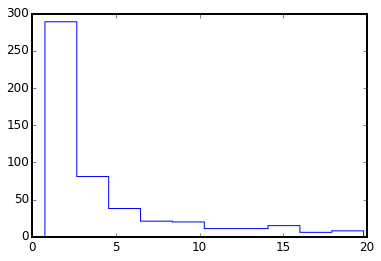

In [20]:
#Here's an example of the true population.

theta = [-0.3, -1.5, -0.8, 0.0, 0.3]
rps = [draw_planet(theta)[0] for i in range(500)]
plt.hist(rps, histtype='step');

In [21]:
#generate population with no binaries
theta = [-0.3, -1.5, -0.8, 0.0, 0.3]
df = generate_planets(theta, stlr)
df.to_hdf('synthetic_kois_single.h5','df')

309 planets generated (0 of 91637 stars skipped.)


In [22]:
#generate population with binaries
theta = [-0.3, -1.5, -0.8, 0.5, 0.3]
df = generate_planets(theta, stlr)
df.to_hdf('synthetic_kois_binaries.h5','df')

235 planets generated (35 of 91637 stars skipped.)


OK, let's try to apply dan's population inference model:

In [8]:
kois = pd.read_hdf('synthetic_kois_single.h5', 'df')

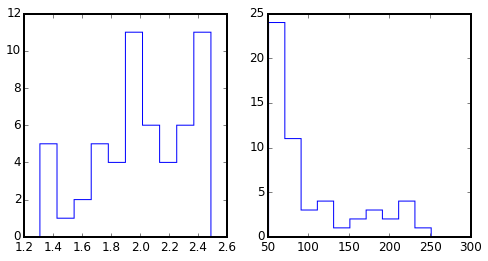

In [59]:
fig, (ax1, ax2) = pl.subplots(1,2, figsize=(8,4))
ax1.hist(kois.koi_prad_true, histtype='step');
ax2.hist(kois.koi_period, histtype='step');

Get "completeness" with standard assumptions.  Need to tweak to use straight-up MES=10 threshold.

In [27]:
rp_rng

(0.75, 20)

In [5]:
period = np.linspace(period_rng[0], 
                     period_rng[1], 45)
rp = np.linspace(rp_rng[0], 
                 rp_rng[1], 101)
period_grid, rp_grid = np.meshgrid(period, rp, indexing="ij")
comp = np.zeros_like(period_grid)
for _, star in stlr.iterrows():
    try:
        comp += get_completeness(star, period_grid, rp_grid, 
                                 0.0, with_geom=True, thresh=10)
    except ValueError:
        continue

In [39]:
np.savez('completeness', comp=comp, period_grid=period_grid, rp_grid=rp_grid,
         inds=stlr.index, thresh=10)

In [6]:
kois = pd.read_hdf('synthetic_kois_single.h5', 'df')

# A double power law model for the population.
def population_model(theta, period, rp):
    lnf0, beta, alpha = theta
    v = np.exp(lnf0) * np.ones_like(period)
    for x, rng, n in zip((period, rp),
                         (period_rng, rp_rng),
                         (beta, alpha)):
        n1 = n + 1
        v *= x**n*n1 / (rng[1]**n1-rng[0]**n1)
    return v

# The ln-likelihood function given at the top of this post.
koi_periods = np.array(kois.koi_period)
koi_rps = np.array(kois.koi_prad)
vol = np.diff(period_grid, axis=0)[:, :-1] * np.diff(rp_grid, axis=1)[:-1, :]
def lnlike(theta):
    pop = population_model(theta, period_grid, rp_grid) * comp
    pop = 0.5 * (pop[:-1, :-1] + pop[1:, 1:])
    norm = np.sum(pop * vol)
    ll = np.sum(np.log(population_model(theta, koi_periods, koi_rps))) - norm
    return ll if np.isfinite(ll) else -np.inf

# The ln-probability function is just propotional to the ln-likelihood
# since we're assuming uniform priors.
bounds = [(-5, 5), (-5, 5), (-5, 5)]
def lnprob(theta):
    # Broad uniform priors.
    for t, rng in zip(theta, bounds):
        if not rng[0] < t < rng[1]:
            return -np.inf
    return lnlike(theta)

# The negative ln-likelihood is useful for optimization.
# Optimizers want to *minimize* your function.
def nll(theta):
    ll = lnlike(theta)
    return -ll if np.isfinite(ll) else 1e15

In [7]:
from scipy.optimize import minimize
theta_0 = np.array([-0.3, -1.5, -0.8])
r = minimize(nll, theta_0, method="L-BFGS-B", bounds=bounds)
print(r)

   status: 0
  success: True
     nfev: 40
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      fun: 2934.1378321581096
        x: array([-0.22458488, -0.80007225, -1.61058431])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
      jac: array([ 0.00295586, -0.00459295, -0.00163709])
      nit: 8


[ 0.32638394]


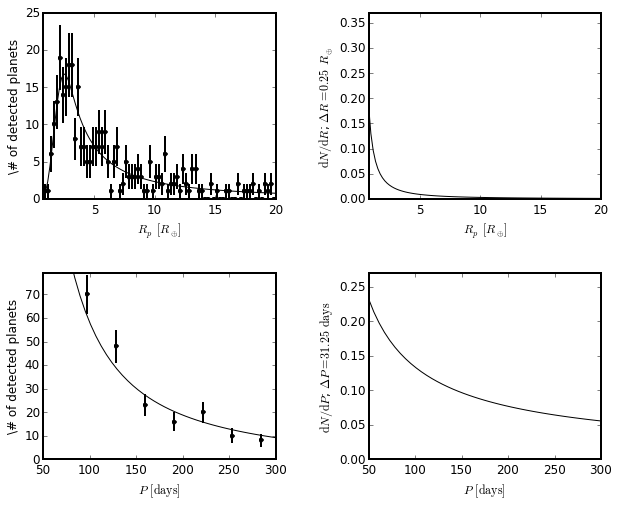

In [8]:
%matplotlib inline
import matplotlib.pyplot as pl

# We'll reuse these functions to plot all of our results.
def make_plot(pop_comp, x0, x, y, ax):
    pop = 0.5 * (pop_comp[:, 1:] + pop_comp[:, :-1])
    pop = np.sum(pop * np.diff(y)[None, :, None], axis=1)
    a, b, c, d, e = np.percentile(pop * np.diff(x)[0], [2.5, 16, 50, 84, 97.5], axis=0)

    ax.fill_between(x0, a, e, color="k", alpha=0.1, edgecolor="none")
    ax.fill_between(x0, b, d, color="k", alpha=0.3, edgecolor="none")
    ax.plot(x0, c, "k", lw=1)

def plot_results(samples):
    # Loop through the samples and compute the list of population models.
    samples = np.atleast_2d(samples)
    pop = np.empty((len(samples), period_grid.shape[0], period_grid.shape[1]))
    gamma_earth = np.empty((len(samples)))
    for i, p in enumerate(samples):
        pop[i] = population_model(p, period_grid, rp_grid)
        gamma_earth[i] = population_model(p, 365.25, 1.0) * 365.
        
    fig, axes = pl.subplots(2, 2, figsize=(10, 8))
    fig.subplots_adjust(wspace=0.4, hspace=0.4)
    
    # Integrate over period.
    dx = 0.25
    x = np.arange(rp_rng[0], rp_rng[1] + dx, dx)
    n, _ = np.histogram(koi_rps, x)
    
    # Plot the observed radius distribution.
    ax = axes[0, 0]
    make_plot(pop * comp[None, :, :], rp, x, period, ax)
    ax.errorbar(0.5*(x[:-1]+x[1:]), n, yerr=np.sqrt(n), fmt=".k",
                capsize=0)
    ax.set_xlim(rp_rng[0], rp_rng[1])
    ax.set_xlabel("$R_p\,[R_\oplus]$")
    ax.set_ylabel("\# of detected planets")
    
    # Plot the true radius distribution.
    ax = axes[0, 1]
    make_plot(pop, rp, x, period, ax)
    ax.set_xlim(rp_rng[0], rp_rng[1])
    ax.set_ylim(0, 0.37)
    ax.set_xlabel("$R_p\,[R_\oplus]$")
    ax.set_ylabel("$\mathrm{d}N / \mathrm{d}R$; $\Delta R = 0.25\,R_\oplus$")
    
    # Integrate over period.
    dx = 31.25
    x = np.arange(period_rng[0], period_rng[1] + dx, dx)
    n, _ = np.histogram(koi_periods, x)
    
    # Plot the observed period distribution.
    ax = axes[1, 0]
    make_plot(np.swapaxes(pop * comp[None, :, :], 1, 2), period, x, rp, ax)
    ax.errorbar(0.5*(x[:-1]+x[1:]), n, yerr=np.sqrt(n), fmt=".k",
                capsize=0)
    ax.set_xlim(period_rng[0], period_rng[1])
    ax.set_ylim(0, 79)
    ax.set_xlabel("$P\,[\mathrm{days}]$")
    ax.set_ylabel("\# of detected planets")
    
    # Plot the true period distribution.
    ax = axes[1, 1]
    make_plot(np.swapaxes(pop, 1, 2), period, x, rp, ax)
    ax.set_xlim(period_rng[0], period_rng[1])
    ax.set_ylim(0, 0.27)
    ax.set_xlabel("$P\,[\mathrm{days}]$")
    ax.set_ylabel("$\mathrm{d}N / \mathrm{d}P$; $\Delta P = 31.25\,\mathrm{days}$")
    
    return gamma_earth

print(plot_results(r.x));

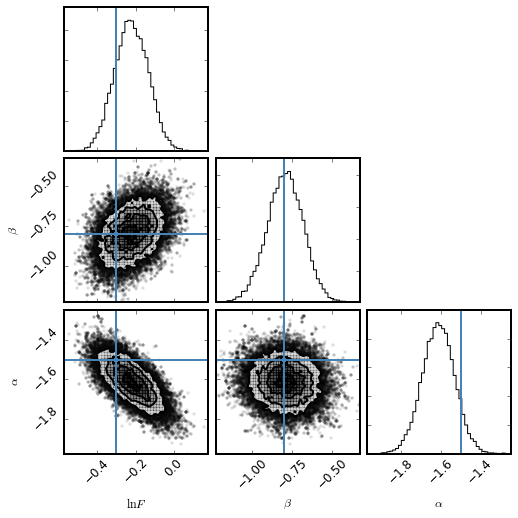

In [9]:
import emcee

ndim, nwalkers = len(r.x), 16
pos = [r.x + 1e-5 * np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

# Burn in.
pos, _, _ = sampler.run_mcmc(pos, 1000)
sampler.reset()

# Production.
pos, _, _ = sampler.run_mcmc(pos, 4000)

import triangle
triangle.corner(sampler.flatchain, labels=[r"$\ln F$", r"$\beta$", r"$\alpha$"],
               truths=[-0.3, -0.8, -1.5]);

In [ ]:
#gamma_earth = plot_results(sampler.flatchain)  #why does this freak out?

OK, now for binaries!

In [10]:
kois = pd.read_hdf('synthetic_kois_binaries.h5', 'df')

# A double power law model for the population.
def population_model(theta, period, rp):
    lnf0, beta, alpha = theta
    v = np.exp(lnf0) * np.ones_like(period)
    for x, rng, n in zip((period, rp),
                         (period_rng, rp_rng),
                         (beta, alpha)):
        n1 = n + 1
        v *= x**n*n1 / (rng[1]**n1-rng[0]**n1)
    return v

# The ln-likelihood function given at the top of this post.
koi_periods = np.array(kois.koi_period)
koi_rps = np.array(kois.koi_prad)
vol = np.diff(period_grid, axis=0)[:, :-1] * np.diff(rp_grid, axis=1)[:-1, :]
def lnlike(theta):
    pop = population_model(theta, period_grid, rp_grid) * comp
    pop = 0.5 * (pop[:-1, :-1] + pop[1:, 1:])
    norm = np.sum(pop * vol)
    ll = np.sum(np.log(population_model(theta, koi_periods, koi_rps))) - norm
    return ll if np.isfinite(ll) else -np.inf

# The ln-probability function is just propotional to the ln-likelihood
# since we're assuming uniform priors.
bounds = [(-5, 5), (-5, 5), (-5, 5)]
def lnprob(theta):
    # Broad uniform priors.
    for t, rng in zip(theta, bounds):
        if not rng[0] < t < rng[1]:
            return -np.inf
    return lnlike(theta)

# The negative ln-likelihood is useful for optimization.
# Optimizers want to *minimize* your function.
def nll(theta):
    ll = lnlike(theta)
    return -ll if np.isfinite(ll) else 1e15

In [ ]:
import emcee

ndim, nwalkers = len(r.x), 16
pos = [r.x + 1e-5 * np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

# Burn in.
pos, _, _ = sampler.run_mcmc(pos, 1000)
sampler.reset()

# Production.
pos, _, _ = sampler.run_mcmc(pos, 4000)

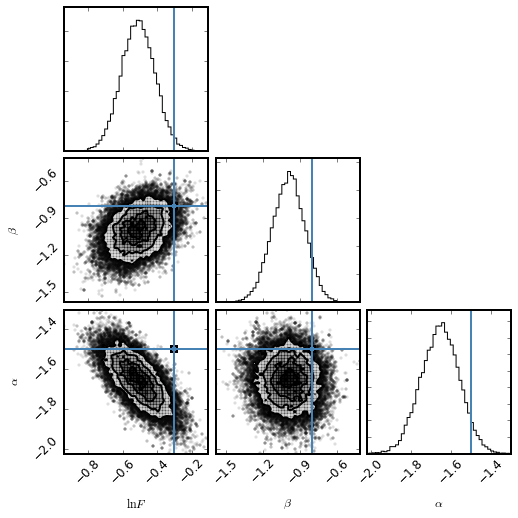

In [13]:
import triangle
triangle.corner(sampler.flatchain, labels=[r"$\ln F$", r"$\beta$", r"$\alpha$"],
               truths=[-0.3, -0.8, -1.5]);

In [14]:
np.exp(-0.6)/np.exp(-0.3)

0.74081822068171799

In [15]:
kois.head()

,kepid,koi_max_mult_ev,koi_period,koi_prad,koi_prad_true
0,10031918,73.778803,230.515361,4.672112,4.672112
1,10063483,64.233580,93.510953,2.382100,2.382100
2,10153673,29.301081,101.358327,2.686735,2.686735
3,10026578,69.559614,98.094239,6.978781,6.978781
4,10121916,87.184006,134.631498,4.290389,4.328801


In [18]:
(kois.koi_prad_true / kois.koi_prad).mean()

1.1231775068409957

In [29]:
theta = [-0.3, -1.5, -0.8, 0.5, 0.3]

In [30]:
pd.Series(theta).to_hdf('test.h5', 'theta')

In [31]:
theta = list(pd.read_hdf('test.h5', 'theta'))

In [32]:
theta

[-0.29999999999999999, -1.5, -0.80000000000000004, 0.5, 0.29999999999999999]

In [36]:
import os.path
os.path.splitext('thiet/thie/thiets.df')[0]

'thiet/thie/thiets'

In [38]:
d.keys()

['comp', 'thresh', 'period_grid', 'inds']